# Marine Heatwave Animation of North Pacific Anomalies 

***
Author: Hillary Scannell: https://github.com/hscannell

This notebook animates a map of marine heatwave sea surface temperature anomalies in the North Pacific.Marine heatwaves are defined as sea surface temperature that exceeds the 90th percentile using a fixed 30-year (1988-2017) climatology. This notebook reads in data stored as **mhw_stats_NP.npz** and **OISSTv2.NP.1981.2018.nc** that were created in [**MHWclassify.ipynb**](https://github.com/cse512-18s/marine-heatwave/blob/master/data/MHWclassify.ipynb), [**webgetOISST.txt**](https://github.com/cse512-18s/marine-heatwave/blob/master/data/webgetOISSTnetCDF.txt), and [**concatOISST.txt**](https://github.com/cse512-18s/marine-heatwave/blob/master/data/concatOISST.txt).


## Step #1. Import Python Libraries & Define Functions

***

In [8]:
import numpy as np
import os
from matplotlib import animation
from calendar import monthrange
from netCDF4 import Dataset
from moviepy.editor import VideoClip
import datetime 
from datetime import date
import time 
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cairo
import gizeh
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.dates as mdates
import matplotlib.cbook as cbook


def nans(shape, dtype=float):
    a = np.empty(shape, dtype)
    a.fill(np.nan)
    return a

## Step #2. Load Data

Specifiy the path to where the data is stored on your machine. 
**(i.e. change _path_ and _fp_ in cell below**)

***

In [5]:
# Set your path to where you stored data from MHWclassify.ipynb 
path = "/Users/Scannell/Desktop/marine-heatwave/data/" 
os.chdir(path)
print ('Did you get an error? if [Y], check that you have the right path. Curent directory =',os.getcwd(),'if [N] ignore')
data = np.load('mhw_stats_NP.npz') 
#ssta = data['ssta']
climatologoy_threshold = data['climatologoy_threshold']


# Set your path to where you stored the netCDF data from concatOISST.txt
fp = "/Users/Scannell/Desktop/marine-heatwave/data/ftp.cdc.noaa.gov/Datasets/noaa.oisst.v2.highres/OISSTv2.NP.1981.2018.nc" 
print ('Did you get an error? if [Y], Check that you have the right path. Curent directory =',os.getcwd(),'if [N] ignore')
file2read = Dataset(fp) # reading the nc file and creating a dataset
t = file2read.variables['time'][:] # time is given in days since 1800-01-01 00:00:00
ref = datetime.date(1800,1,1).toordinal() 
time = ref + t
lon = file2read.variables['lon'][:]
lat = file2read.variables['lat'][:]
sst = file2read.variables['sst'][:]

###########
ssta = sst - data['seasonal_climatology']


Did you get an error? Check that you have the right path. Curent directory = /Users/Scannell/Desktop/marine-heatwave/data
Did you get an error? Check that you have the right path. Curent directory = /Users/Scannell/Desktop/marine-heatwave/data


## Step #3. Create Labels for Marine Heatwaves


***

In [7]:
# Initialize matrix
MHW_lbls = nans([13415,180,520])
n = sst.size
p = climatologoy_threshold.size
X = np.reshape(sst,n)
Y = np.reshape(climatologoy_threshold,n)
I=np.array(np.where(X>Y)[0])
lbls = nans(n)
lbls[I] = np.ones(len(I))
mhw_lbls = np.reshape(lbls, (13415, 180, 520))

# Create matrix of just MHW anomalies 
Z = np.reshape(ssta,n)
mhw_anoms = nans(n)
mhw_anoms[I] = Z[I]
mhw_anoms = np.reshape(mhw_anoms, (13415, 180, 520))

## Step #4. Create Maps of Marine Heatwave Anomalies

Specify directory (***fig_dir***) where figures will be saved. Saves figure as ***mhw_anom_yyyy_mm_dd.png***

***

In [45]:
fig_dir = "/Users/Scannell/Desktop/marine-heatwave/images/" 
os.chdir(fig_dir)


fig = plt.figure(figsize=(20, 20)) # 8,10
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

# Loop through different months in 2014, plot data and save maps to current directory
for j in range(2,9): # set at range(2,9) or month February through August
    [n,p]=monthrange(2014, j)
    for i in range(1,p+1):
        t_fig= int(date(2014, j, i).toordinal())
        t_ind = (np.where(time==t_fig))[0] 

        # Label axes of a Plate Carree projection with a central longitude of 180:
        ax1 = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180))
        ax1.set_global()
        ax1.coastlines()
        ax1.set_extent([-55, 80, 20, 65], crs=ccrs.PlateCarree(central_longitude=180))
        ax1.set_xticks([140,160,180,200,220,240], crs=ccrs.PlateCarree())
        ax1.set_yticks([30,45,60], crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax1.xaxis.set_major_formatter(lon_formatter)
        ax1.yaxis.set_major_formatter(lat_formatter)
        #levels = [-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3] # levels for all anomalies
        #levels = [0,1] # level for labels
        levels = [0.5,1,1.5,2,2.5,3,3.5,4] # levels for only marine heatwave anomalies
        ax1.add_feature(cfeature.LAND,facecolor='k')
        CS = plt.contourf(lon-180, lat, np.squeeze(mhw_anoms[t_ind,:,:]), levels, cmap=plt.cm.gist_heat_r,extend='both')
        cbar = plt.colorbar(CS, shrink=0.6)
        cbar.ax.set_ylabel('SST Anomaly [$^\circ$C]',fontname='Arial',fontsize=20)
        ttl = plt.title('%i-%02d-%02d' % (date.fromordinal(int(time[t_ind])).year,date.fromordinal(int(time[t_ind])).month,date.fromordinal(int(time[t_ind])).day),fontname='Arial',fontsize=20)

        fig.savefig(('mhw_anom_%i_%02d_%02d' % (date.fromordinal(int(time[t_ind])).year,date.fromordinal(int(time[t_ind])).month,date.fromordinal(int(time[t_ind])).day)),bbox_inches='tight')
        print(('mhw_anom_%i_%02d_%02d.png' % (date.fromordinal(int(time[t_ind])).year,date.fromordinal(int(time[t_ind])).month,date.fromordinal(int(time[t_ind])).day)))
        plt.clf()
            

mhw_anom_2014_02_01.png
mhw_anom_2014_02_02.png
mhw_anom_2014_02_03.png
mhw_anom_2014_02_04.png
mhw_anom_2014_02_05.png
mhw_anom_2014_02_06.png
mhw_anom_2014_02_07.png
mhw_anom_2014_02_08.png
mhw_anom_2014_02_09.png
mhw_anom_2014_02_10.png
mhw_anom_2014_02_11.png
mhw_anom_2014_02_12.png
mhw_anom_2014_02_13.png
mhw_anom_2014_02_14.png
mhw_anom_2014_02_15.png
mhw_anom_2014_02_16.png
mhw_anom_2014_02_17.png
mhw_anom_2014_02_18.png
mhw_anom_2014_02_19.png
mhw_anom_2014_02_20.png
mhw_anom_2014_02_21.png
mhw_anom_2014_02_22.png
mhw_anom_2014_02_23.png
mhw_anom_2014_02_24.png
mhw_anom_2014_02_25.png
mhw_anom_2014_02_26.png
mhw_anom_2014_02_27.png
mhw_anom_2014_02_28.png
mhw_anom_2014_03_01.png
mhw_anom_2014_03_02.png
mhw_anom_2014_03_03.png
mhw_anom_2014_03_04.png
mhw_anom_2014_03_05.png
mhw_anom_2014_03_06.png
mhw_anom_2014_03_07.png
mhw_anom_2014_03_08.png
mhw_anom_2014_03_09.png
mhw_anom_2014_03_10.png
mhw_anom_2014_03_11.png
mhw_anom_2014_03_12.png
mhw_anom_2014_03_13.png
mhw_anom_2014_03

## Step #5. Plot Time Series of Sea Surface Temperature Anomalies at 46ºN, 144ºW

Saves figure to current directory ( _fig__dir_) as ***46n144w_ts.png***
***


(array([104]),) (array([364]),)
latitude 46.125 and longitude 216.125


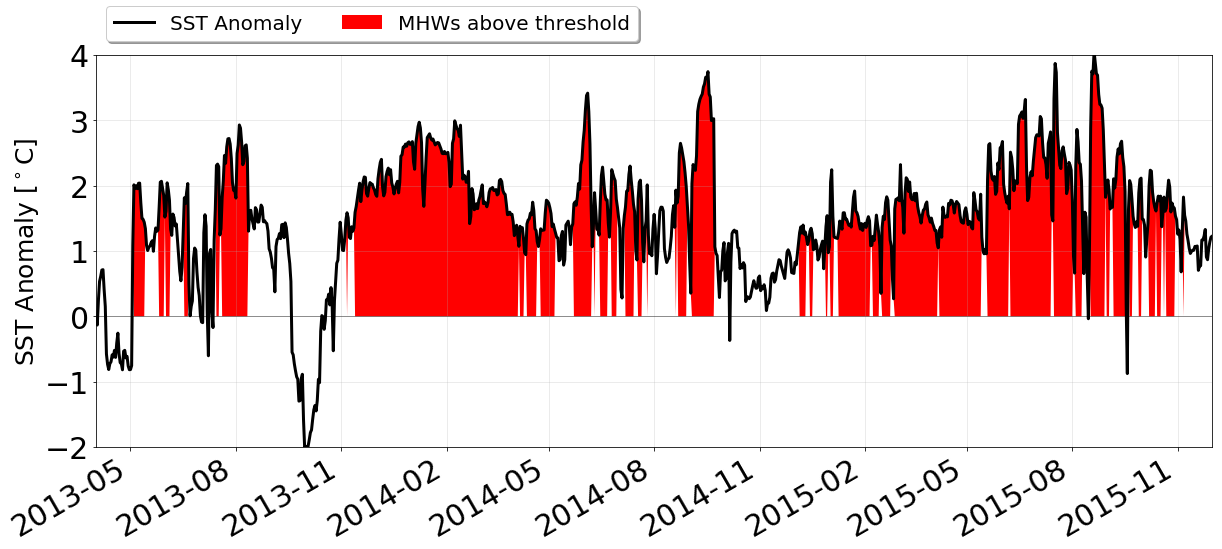

In [46]:
# Index time
T = len(time)
t_start= int(date(2013, 4, 1).toordinal())
t_end = int(date(2015, 12, 1).toordinal())
index_start = np.asscalar(np.where(time==t_start)[0])
index_end = np.asscalar(np.where(time == t_end)[0])
time_slice = np.arange(time[index_start],time[index_end+1])
dates = [date.fromordinal(tt.astype(int)) for tt in time_slice]

# Index location
print(np.where(lat==46.125),np.where(lon==216.125))
print('latitude',lat[104],'and longitude',lon[364])
i = 104
j = 364

# Make Plot
fig = plt.figure(figsize=(20, 8)) # 8,10
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30)
y1 = ssta[index_start:index_end+1,i,j]
y2 = np.zeros(len(time_slice))
plt.fill_between(dates, y1, y2, where=sst[index_start:index_end+1,i,j] > climatologoy_threshold[index_start:index_end+1,i,j], facecolor='red', interpolate=True,label="MHWs above threshold")
a= plt.plot(dates,np.squeeze(ssta[index_start:index_end+1,i,j]),'k',label="SST Anomaly",linewidth = 3)
b= plt.plot(dates,np.zeros(len(time_slice)),'k',linewidth = 1,alpha = 0.4)
plt.legend(loc="upper left", bbox_to_anchor=[0, 1.15],ncol=3, shadow=True, fancybox=True,fontsize=20)
_=plt.ylabel('SST Anomaly [$^\circ$C]',size=25)
plt.gcf().autofmt_xdate()
plt.grid(True,alpha = 0.3)
plt.xlim(dates[0], dates[-1])
plt.ylim(-2,4)

fig.savefig('46n144w_ts.png',bbox_inches='tight')


## Step #6. Create Interactive JavaScript Widget for North Pacific Marine Heatwave Anomalies


***

In [ ]:
# Index into time for the Pacific Marine Heatwave
t_start= int(date(2013, 4, 1).toordinal())
t_end = int(date(2015, 12, 1).toordinal())
index_start = np.asscalar(np.where(time==t_start)[0])
index_end = np.asscalar(np.where(time == t_end)[0])
time_slice = np.arange(time[index_start],time[index_end+1])
n = len(time_slice)


plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30)
fig,ax = plt.subplots(111,figsize=(20,10))

# Label axes of a Plate Carree projection with a central longitude of 180:
ax1 = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_global()
ax1.set_extent([-55, 80, 20, 65], crs=ccrs.PlateCarree(central_longitude=180))
ax1.set_xticks([140,160,180,200,220,240], crs=ccrs.PlateCarree())
ax1.set_yticks([30,45,60], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.add_feature(cfeature.LAND,facecolor='k')
levels = [0.5,1,1.5,2,2.5,3,3.5,4]
cont=plt.contourf(lon-180, lat, np.squeeze(mhw_anoms[0,:,:]), levels, cmap=plt.cm.gist_heat_r,extend='both')
cbar = plt.colorbar(cont, shrink=0.6, cmap=plt.cm.gist_heat_r,extend='both')
cbar.ax.set_ylabel('SST Anomaly [$^\circ$C]',fontname='Arial',fontsize=26)

def animate(i): 
    
    ax1 = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
    ax1.clear()
    levels = [0.5,1,1.5,2,2.5,3,3.5,4]
    cont = plt.contourf(lon-180, lat, mhw_anoms[i,:,:],levels,cmap=plt.cm.gist_heat_r,extend='both')
    #cont.set_data(lon-180, lat, mhw_anoms[i,:,:],levels,cmap=plt.cm.gist_heat_r,extend='both')
    ax1 = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
    ax1.set_global()
    ax1.set_extent([-55, 80, 20, 65], crs=ccrs.PlateCarree(central_longitude=180))
    ax1.set_xticks([140,160,180,200,220,240], crs=ccrs.PlateCarree())
    ax1.set_yticks([30,45,60], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    ax1.add_feature(cfeature.LAND,facecolor='k')
    ttl = plt.title('%i-%02d-%02d' % (date.fromordinal(int(time_slice[i])).year,date.fromordinal(int(time_slice[i])).month,date.fromordinal(int(time_slice[i])).day),fontname='Arial',fontsize=30)
    return cont, 

        

anim = animation.FuncAnimation(fig, animate, frames=n)

HTML(anim.to_jshtml()) # Convert animation to JavaScript:

anim.save('mhw.html', dpi=80, writer='imagemagick')

